In [4]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

# Load libraries and set device engine

In [5]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


# Load Dataset and split data

In [6]:
def load_calhous_dataset():
    # Load California housing dataset
    calhous = fetch_california_housing()
    data = calhous.data
    target = calhous.target

    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.float32)

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.2, random_state=42)

    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=1, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=1, shuffle=False)

    train_inputs = torch.empty(0, data_tensor.size(1), device=device)
    train_labels = torch.empty(0, dtype=torch.float32, device=device)
    test_inputs = torch.empty(0, data_tensor.size(1), device=device)
    test_labels = torch.empty(0, dtype=torch.float32, device=device)

    # Concatenate all data into a single tensor on the specified device
    for data, labels in tqdm(train_loader):
        train_inputs = torch.cat((train_inputs, data.to(device)), dim=0)
        train_labels = torch.cat((train_labels, labels.to(device)), dim=0)

    for data, labels in tqdm(test_loader):
        test_inputs = torch.cat((test_inputs, data.to(device)), dim=0)
        test_labels = torch.cat((test_labels, labels.to(device)), dim=0)

    dataset = {}
    dataset['train_input'] = train_inputs
    dataset['test_input'] = test_inputs
    dataset['train_label'] = train_labels.reshape(-1, 1)
    dataset['test_label'] = test_labels.reshape(-1, 1)

    return dataset

dataset = load_calhous_dataset()

100%|██████████| 4128/4128 [00:02<00:00, 1752.15it/s]


In [7]:
#input_vars = ['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']
input_vars = ['MI','HA','AR','AB','P','AO','La','Lo']

In [8]:
print("Train data shape: {}".format(dataset['train_input'].shape))
print("Train target shape: {}".format(dataset['train_label'].shape))
print("Test data shape: {}".format(dataset['test_input'].shape))
print("Test target shape: {}".format(dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([16512, 8])
Train target shape: torch.Size([16512, 1])
Test data shape: torch.Size([4128, 8])
Test target shape: torch.Size([4128, 1])


In [6]:
dataset['test_label']

tensor([[0.4770],
        [0.4580],
        [5.0000],
        ...,
        [5.0000],
        [0.7230],
        [1.5150]], device='cuda:0')

# Create Kan Network

In [9]:
# 8 inputs, 3 hidden, 1 output
model = KAN(width=[8, 3, 1], grid=10, k=3, seed=0, device=device)

checkpoint directory created: ./model
saving model version 0.0


# Train dataset

In [10]:
results = model.fit(dataset, opt="LBFGS", steps=20, lamb=0.01, reg_metric='edge_forward_spline_n')

| train_loss: 5.53e-01 | test_loss: 5.64e-01 | reg: 8.43e+00 | : 100%|█| 20/20 [00:33<00:00,  1.69s/

saving model version 0.1


In [17]:
results

{'train_loss': [array(0.740381, dtype=float32),
  array(0.6781164, dtype=float32),
  array(0.6580207, dtype=float32),
  array(0.6515422, dtype=float32),
  array(0.6466147, dtype=float32),
  array(0.64676934, dtype=float32),
  array(0.64574337, dtype=float32),
  array(0.64523554, dtype=float32),
  array(0.643936, dtype=float32),
  array(0.64288074, dtype=float32),
  array(0.6424433, dtype=float32),
  array(0.6410117, dtype=float32),
  array(0.6399552, dtype=float32),
  array(0.638975, dtype=float32),
  array(0.63720584, dtype=float32),
  array(0.63389087, dtype=float32),
  array(0.6295582, dtype=float32),
  array(0.62164396, dtype=float32),
  array(0.61896056, dtype=float32),
  array(0.6162458, dtype=float32)],
 'test_loss': [array(0.75640094, dtype=float32),
  array(0.6936641, dtype=float32),
  array(0.67475075, dtype=float32),
  array(0.66871935, dtype=float32),
  array(0.6655119, dtype=float32),
  array(0.6655662, dtype=float32),
  array(0.6645612, dtype=float32),
  array(0.663686, d

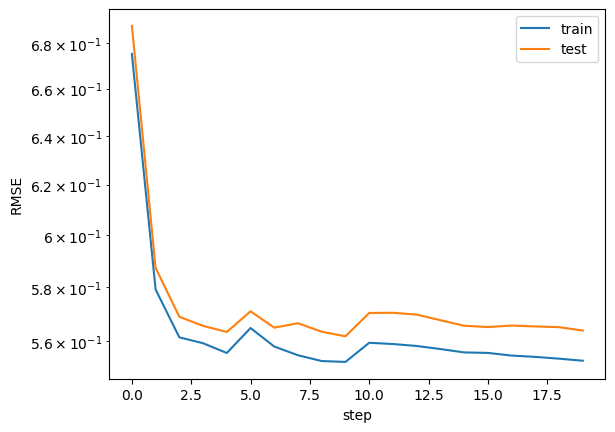

In [11]:
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

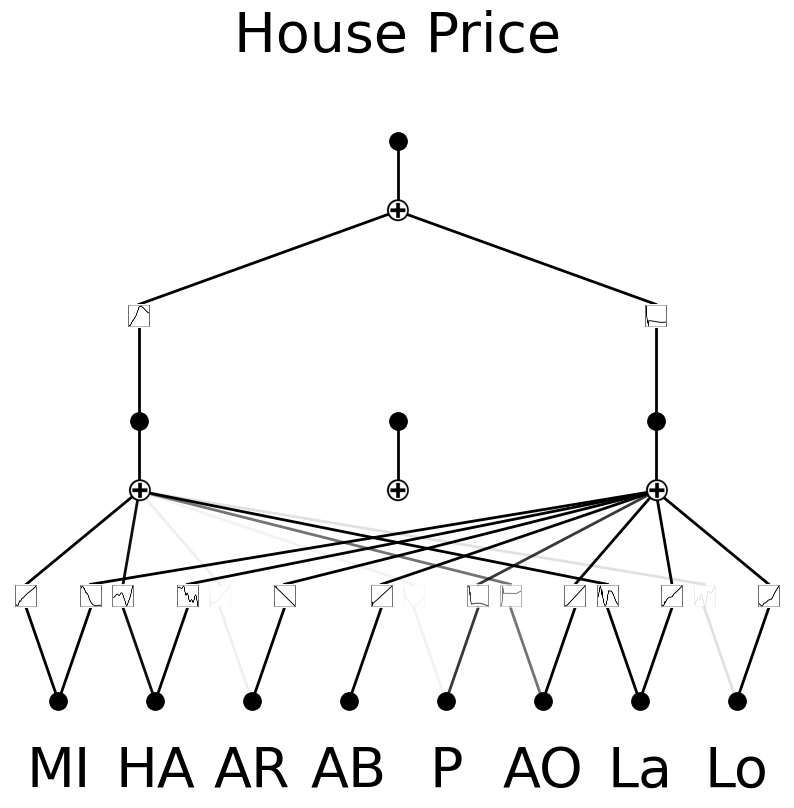

In [9]:
model.plot(beta=50, scale=1,in_vars=input_vars, out_vars=['House Price'])

# Show symbolic formula generated

In [10]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with x, r2=0.9502273797988892, c=1
fixing (0,0,1) with x, r2=0.055618587881326675, c=1
fixing (0,0,2) with x, r2=0.9528959393501282, c=1
fixing (0,1,0) with x, r2=0.0161308404058218, c=1
fixing (0,1,1) with x, r2=0.0850561261177063, c=1
fixing (0,1,2) with x, r2=0.744392454624176, c=1
fixing (0,2,0) with x, r2=0.16013364493846893, c=1
fixing (0,2,1) with x, r2=0.009360791184008121, c=1
fixing (0,2,2) with x, r2=0.7053518891334534, c=1
fixing (0,3,0) with x, r2=0.08577848225831985, c=1
fixing (0,3,1) with x, r2=0.3721088767051697, c=1
fixing (0,3,2) with x, r2=0.3326287269592285, c=1
fixing (0,4,0) with x, r2=0.4314740002155304, c=1
fixing (0,4,1) with x, r2=0.0069606490433216095, c=1
fixing (0,4,2) with x, r2=0.6567000150680542, c=1
fixing (0,5,0) with sin, r2=0.976357638835907, c=2
fixing (0,5,1) with sin, r2=0.9905195236206055, c=2
fixing (0,5,2) with sin, r2=0.9972185492515564, c=2
fixing (0,6,0) with x, r2=0.023350771516561508, c=1
fixing (0,6,1) with x, r2=0.0319875

0.2028*x_1 - 0.0042*x_2 + 0.0004*x_3 - 0.0006*x_5 - 0.011*x_7 + 0.0013*x_8 - 0.e-4*sin(3.6614*x_6 - 4.3839) + 0.0492*sin(5.9486*x_6 - 1.1914) + 0.5109

# Show Feature Importance

In [12]:
model.feature_score

tensor([0.4298, 0.0977, 0.0956, 0.0484, 0.0220, 0.6739, 0.8344, 0.7126],
       device='cuda:0', grad_fn=<MeanBackward1>)